In [33]:
import os
import torch
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
def compute_gsnr(epoch: int, layer_name: str, base_path: str, epsilon=1e-8):
    """
    Computes GSNR for a given layer at a given epoch.
    """
    layer_dir = os.path.join(
        base_path,
        f"grad_info_per_epoch",
        f"epoch{epoch}",
        layer_name
    )

    grad_list = []
    filenames = sorted([
        f for f in os.listdir(layer_dir) if f.endswith(".pt")
    ])

    for fname in filenames:
        grad = torch.load(os.path.join(layer_dir, fname))  # [D]
        grad_list.append(grad)

    grads = torch.stack(grad_list)  # [T, D]
    grad_mean = grads.mean(dim=0)   # [D]

    signal = grad_mean.mean().item() ** 2
    noise = grad_mean.var().item() + epsilon
    gsnr = signal / noise

    print(f"{layer_name} (epoch {epoch}): GSNR = {gsnr:.6f}")
    return gsnr

In [7]:
def compute_gsnr_over_epochs(layer_name: str, base_path: str, epoch_list: list):
    """
    Computes and prints GSNR for a specific layer across multiple epochs.
    """
    results = {}
    for epoch in epoch_list:
        try:
            gsnr = compute_gsnr(epoch, layer_name, base_path)
            results[epoch] = gsnr
        except Exception as e:
            print(f"[Warning] Epoch {epoch} failed: {e}")
    return results

In [8]:
def plot_gsnr_compare_methods_all_layers(maml_base_path: str, our_base_path: str, epoch_list: list):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    plt.figure(figsize=(10, 6))

    for layer_name in layer_names:
        # MAML
        maml_results = compute_gsnr_over_epochs(
            layer_name=layer_name,
            base_path=maml_base_path,
            epoch_list=epoch_list
        )
        sorted_epochs = sorted(maml_results.keys())
        maml_values = [maml_results[ep] for ep in sorted_epochs]
        plt.plot(
            sorted_epochs,
            maml_values,
            label=f"MAML - {layer_name}",
            linestyle='dashed'
        )

        # OURS
        our_results = compute_gsnr_over_epochs(
            layer_name=layer_name,
            base_path=our_base_path,
            epoch_list=epoch_list
        )
        our_values = [our_results[ep] for ep in sorted_epochs]
        plt.plot(
            sorted_epochs,
            our_values,
            label=f"OURS - {layer_name}",
            linestyle='solid'
        )

    plt.xlabel("Epoch")
    plt.ylabel("GSNR")
    plt.title("GSNR Comparison: MAML vs OURS")
    plt.legend(fontsize=9)
    plt.grid(True)
    plt.xticks(sorted(epoch_list))
    plt.tight_layout()
    plt.show()

In [25]:
def plot_gsnr_layerwise_subplots(maml_base_path: str, our_base_path: str, epoch_list: list):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    num_layers = len(layer_names)
    nrows = (num_layers + 1) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 3 * nrows))
    axes = axes.flatten()

    for idx, layer_name in enumerate(layer_names):
        ax = axes[idx]

        # MAML
        maml_results = compute_gsnr_over_epochs(
            layer_name=layer_name,
            base_path=maml_base_path,
            epoch_list=epoch_list
        )
        sorted_epochs = sorted(maml_results.keys())
        maml_values = [maml_results[ep] for ep in sorted_epochs]
        ax.plot(
            sorted_epochs,
            maml_values,
            label="MAML",
            linestyle='dashed'
        )

        # OURS
        our_results = compute_gsnr_over_epochs(
            layer_name=layer_name,
            base_path=our_base_path,
            epoch_list=epoch_list
        )
        our_values = [our_results[ep] for ep in sorted_epochs]
        ax.plot(
            sorted_epochs,
            our_values,
            label="OURS",
            linestyle='solid'
        )

        ax.set_title(layer_name, fontsize=10)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("GSNR")
        ax.grid(True)
        ax.legend(fontsize=8)
        ax.set_xticks(sorted(epoch_list))

    # 제거할 빈 subplot 처리 (예: layer가 5개면 6번째 subplot 삭제)
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [31]:
def plot_and_save_gsnr_layerwise_individual(
    maml_base_path: str,
    our_base_path: str,
    epoch_list: list,
    save_dir: str = "gradient/gsnr"
):
    layer_names = [
        "layer_layer_dict_conv0_conv_weight",
        "layer_layer_dict_conv1_conv_weight",
        "layer_layer_dict_conv2_conv_weight",
        "layer_layer_dict_conv3_conv_weight",
        "layer_layer_dict_linear_weights"
    ]

    # 저장 폴더 생성
    save_dir = os.path.normpath(save_dir)
    os.makedirs(save_dir, exist_ok=True)

    for layer_name in layer_names:
        plt.figure(figsize=(8, 5))

        # MAML
        maml_results = compute_gsnr_over_epochs(
            layer_name=layer_name,
            base_path=maml_base_path,
            epoch_list=epoch_list
        )
        sorted_epochs = sorted(maml_results.keys())
        maml_values = [maml_results[ep] for ep in sorted_epochs]
        plt.plot(
            sorted_epochs,
            maml_values,
            label="MAML",
            linestyle='dashed'
        )

        # OURS
        our_results = compute_gsnr_over_epochs(
            layer_name=layer_name,
            base_path=our_base_path,
            epoch_list=epoch_list
        )
        our_values = [our_results[ep] for ep in sorted_epochs]
        plt.plot(
            sorted_epochs,
            our_values,
            label="OURS",
            linestyle='solid'
        )

        # 그래프 설정
        plt.title(f"GSNR - {layer_name}", fontsize=12)
        plt.xlabel("Epoch")
        plt.ylabel("GSNR")
        plt.grid(True)
        plt.legend()
        plt.xticks(sorted(epoch_list))
        plt.tight_layout()

        # 저장
        filename = f"{layer_name}_gsnr.png"
        save_path = os.path.join(save_dir, filename)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        plt.close()

        print(f"[Saved] {save_path}")


# 통합 비교

layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.163490
layer_layer_dict_conv0_conv_weight (epoch 1): GSNR = 0.060648
layer_layer_dict_conv0_conv_weight (epoch 2): GSNR = 0.368776
layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.044766
layer_layer_dict_conv0_conv_weight (epoch 1): GSNR = 0.224419
layer_layer_dict_conv0_conv_weight (epoch 2): GSNR = 0.453997
layer_layer_dict_conv1_conv_weight (epoch 0): GSNR = 0.015686
layer_layer_dict_conv1_conv_weight (epoch 1): GSNR = 0.044903
layer_layer_dict_conv1_conv_weight (epoch 2): GSNR = 0.083064
layer_layer_dict_conv1_conv_weight (epoch 0): GSNR = 0.005074
layer_layer_dict_conv1_conv_weight (epoch 1): GSNR = 0.028651
layer_layer_dict_conv1_conv_weight (epoch 2): GSNR = 0.081176
layer_layer_dict_conv2_conv_weight (epoch 0): GSNR = 0.016997
layer_layer_dict_conv2_conv_weight (epoch 1): GSNR = 0.007760
layer_layer_dict_conv2_conv_weight (epoch 2): GSNR = 0.013834
layer_layer_dict_conv2_conv_weight (epoch 0): GSNR = 0.001356
layer_la

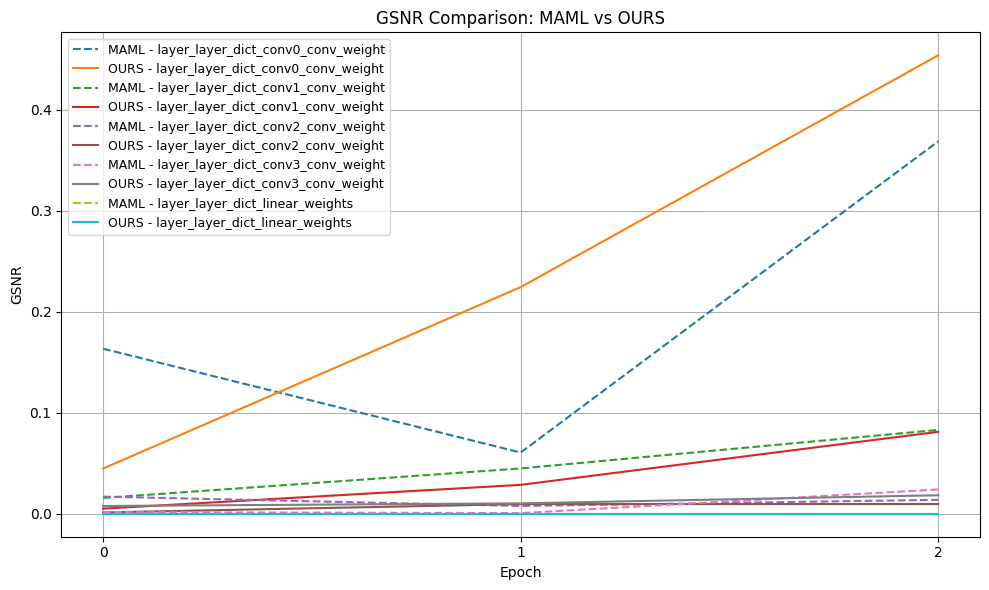

In [24]:
maml_base_path = "../MAML_5way_5shot_filter64_miniImagenet"
our_base_path = "../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet"
epoch_list = list(range(0, 3))  # 예시

plot_gsnr_compare_methods_all_layers(maml_base_path, our_base_path, epoch_list)

layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.163490
layer_layer_dict_conv0_conv_weight (epoch 1): GSNR = 0.060648
layer_layer_dict_conv0_conv_weight (epoch 2): GSNR = 0.368776
layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.044766
layer_layer_dict_conv0_conv_weight (epoch 1): GSNR = 0.224419
layer_layer_dict_conv0_conv_weight (epoch 2): GSNR = 0.453997
layer_layer_dict_conv1_conv_weight (epoch 0): GSNR = 0.015686
layer_layer_dict_conv1_conv_weight (epoch 1): GSNR = 0.044903
layer_layer_dict_conv1_conv_weight (epoch 2): GSNR = 0.083064
layer_layer_dict_conv1_conv_weight (epoch 0): GSNR = 0.005074
layer_layer_dict_conv1_conv_weight (epoch 1): GSNR = 0.028651
layer_layer_dict_conv1_conv_weight (epoch 2): GSNR = 0.081176
layer_layer_dict_conv2_conv_weight (epoch 0): GSNR = 0.016997
layer_layer_dict_conv2_conv_weight (epoch 1): GSNR = 0.007760
layer_layer_dict_conv2_conv_weight (epoch 2): GSNR = 0.013834
layer_layer_dict_conv2_conv_weight (epoch 0): GSNR = 0.001356
layer_la

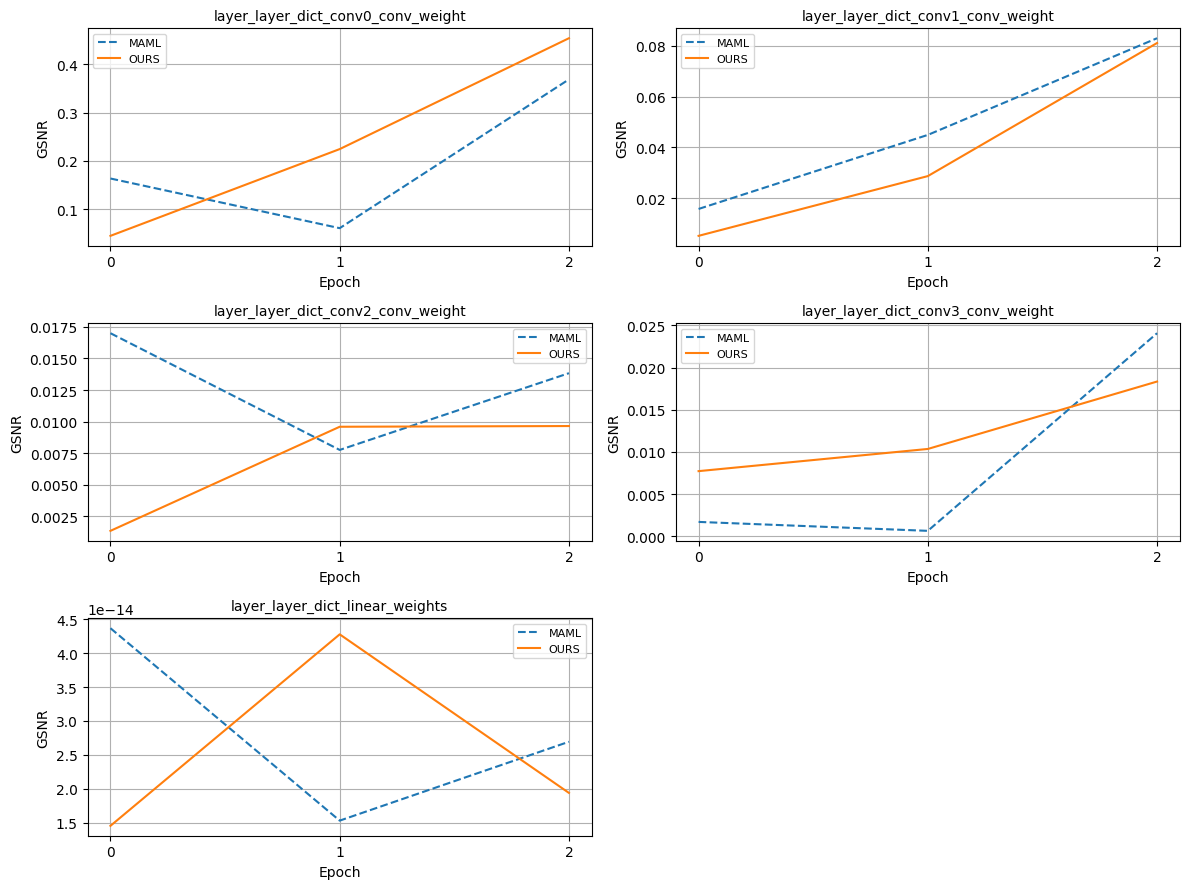

In [26]:
plot_gsnr_layerwise_subplots(maml_base_path, our_base_path, epoch_list)

In [32]:
plot_and_save_gsnr_layerwise_individual(maml_base_path, our_base_path, epoch_list)

layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.163490
layer_layer_dict_conv0_conv_weight (epoch 1): GSNR = 0.060648
layer_layer_dict_conv0_conv_weight (epoch 2): GSNR = 0.368776
layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.044766
layer_layer_dict_conv0_conv_weight (epoch 1): GSNR = 0.224419
layer_layer_dict_conv0_conv_weight (epoch 2): GSNR = 0.453997
[Saved] gradient\gsnr\layer_layer_dict_conv0_conv_weight_gsnr.png
layer_layer_dict_conv1_conv_weight (epoch 0): GSNR = 0.015686
layer_layer_dict_conv1_conv_weight (epoch 1): GSNR = 0.044903
layer_layer_dict_conv1_conv_weight (epoch 2): GSNR = 0.083064
layer_layer_dict_conv1_conv_weight (epoch 0): GSNR = 0.005074
layer_layer_dict_conv1_conv_weight (epoch 1): GSNR = 0.028651
layer_layer_dict_conv1_conv_weight (epoch 2): GSNR = 0.081176
[Saved] gradient\gsnr\layer_layer_dict_conv1_conv_weight_gsnr.png
layer_layer_dict_conv2_conv_weight (epoch 0): GSNR = 0.016997
layer_layer_dict_conv2_conv_weight (epoch 1): GSNR = 0.007760


# MAML

In [10]:
base_path = "../MAML_5way_5shot_filter64_miniImagenet"
epochs = list(range(0, 3))  # 예: 0~9 epoch

In [11]:
compute_gsnr(
    epoch=0,
    layer_name="layer_layer_dict_conv0_conv_weight",
    base_path=our_base_path
)

layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.044766


0.04476636962336588

In [12]:
layer_name = "layer_layer_dict_conv0_conv_weight"
gsnr_results = compute_gsnr_over_epochs(layer_name, base_path, epochs)

layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.163490
layer_layer_dict_conv0_conv_weight (epoch 1): GSNR = 0.060648
layer_layer_dict_conv0_conv_weight (epoch 2): GSNR = 0.368776


In [13]:
layer_name = "layer_layer_dict_conv1_conv_weight"
gsnr_results = compute_gsnr_over_epochs(layer_name, base_path, epochs)

layer_layer_dict_conv1_conv_weight (epoch 0): GSNR = 0.015686
layer_layer_dict_conv1_conv_weight (epoch 1): GSNR = 0.044903
layer_layer_dict_conv1_conv_weight (epoch 2): GSNR = 0.083064


In [14]:
layer_name = "layer_layer_dict_conv2_conv_weight"
gsnr_results = compute_gsnr_over_epochs(layer_name, base_path, epochs)

layer_layer_dict_conv2_conv_weight (epoch 0): GSNR = 0.016997
layer_layer_dict_conv2_conv_weight (epoch 1): GSNR = 0.007760
layer_layer_dict_conv2_conv_weight (epoch 2): GSNR = 0.013834


In [15]:
layer_name = "layer_layer_dict_conv3_conv_weight"
gsnr_results = compute_gsnr_over_epochs(layer_name, base_path, epochs)

layer_layer_dict_conv3_conv_weight (epoch 0): GSNR = 0.001702
layer_layer_dict_conv3_conv_weight (epoch 1): GSNR = 0.000643
layer_layer_dict_conv3_conv_weight (epoch 2): GSNR = 0.024073


In [16]:
layer_name = "layer_layer_dict_linear_weights"
gsnr_results = compute_gsnr_over_epochs(layer_name, base_path, epochs)

layer_layer_dict_linear_weights (epoch 0): GSNR = 0.000000
layer_layer_dict_linear_weights (epoch 1): GSNR = 0.000000
layer_layer_dict_linear_weights (epoch 2): GSNR = 0.000000


# Our

In [17]:
our_base_path = "../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet"

In [18]:
compute_gsnr(
    epoch=0,
    layer_name="layer_layer_dict_conv0_conv_weight",
    base_path=our_base_path
)

layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.044766


0.04476636962336588

In [19]:
layer_name = "layer_layer_dict_conv0_conv_weight"
gsnr_results = compute_gsnr_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_conv0_conv_weight (epoch 0): GSNR = 0.044766
layer_layer_dict_conv0_conv_weight (epoch 1): GSNR = 0.224419
layer_layer_dict_conv0_conv_weight (epoch 2): GSNR = 0.453997


In [20]:
layer_name = "layer_layer_dict_conv1_conv_weight"
gsnr_results = compute_gsnr_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_conv1_conv_weight (epoch 0): GSNR = 0.005074
layer_layer_dict_conv1_conv_weight (epoch 1): GSNR = 0.028651
layer_layer_dict_conv1_conv_weight (epoch 2): GSNR = 0.081176


In [21]:
layer_name = "layer_layer_dict_conv2_conv_weight"
gsnr_results = compute_gsnr_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_conv2_conv_weight (epoch 0): GSNR = 0.001356
layer_layer_dict_conv2_conv_weight (epoch 1): GSNR = 0.009594
layer_layer_dict_conv2_conv_weight (epoch 2): GSNR = 0.009650


In [22]:
layer_name = "layer_layer_dict_conv3_conv_weight"
gsnr_results = compute_gsnr_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_conv3_conv_weight (epoch 0): GSNR = 0.007721
layer_layer_dict_conv3_conv_weight (epoch 1): GSNR = 0.010351
layer_layer_dict_conv3_conv_weight (epoch 2): GSNR = 0.018344


In [23]:
layer_name = "layer_layer_dict_linear_weights"
gsnr_results = compute_gsnr_over_epochs(layer_name, our_base_path, epochs)

layer_layer_dict_linear_weights (epoch 0): GSNR = 0.000000
layer_layer_dict_linear_weights (epoch 1): GSNR = 0.000000
layer_layer_dict_linear_weights (epoch 2): GSNR = 0.000000
